<font color="gray">

### 0. Ensure CUDA and torch is loaded correctly


Also ensure on Rockfish that you are using only 1/however GPUs you specified, not 4

</font>

In [ ]:
!export CUDA_VISIBLE_DEVICES=0

In [1]:
!nvidia-smi

Thu Oct  3 15:46:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB           On | 00000000:06:00.0 Off |                    0 |
| N/A   66C    P0               85W / 250W|   4437MiB / 40960MiB |     53%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
import torch
print(torch.cuda.device_count())

1


If the below says 10.2, you will get the `sm_80` CUDA compatibility warning

In [3]:
torch.version.cuda

'11.3'

# 1. Load Tensors

In [5]:
import torch
import pickle

# Load the tensor
all_sampled_cubes = torch.load('data/all_sampled_cubes.pt')

# Load the list of patient IDs
with open('data/all_filtered_ids.pkl', 'rb') as f:
    all_filtered_ids = pickle.load(f)


print(all_sampled_cubes.shape)
print(all_filtered_ids[:10])
assert len(all_sampled_cubes) == len(all_filtered_ids)

torch.Size([50, 55, 96, 96, 96])
['BDMAP_00000002', 'BDMAP_00000110', 'BDMAP_00000198', 'BDMAP_00000246', 'BDMAP_00000351', 'BDMAP_00000598', 'BDMAP_00000673', 'BDMAP_00000682', 'BDMAP_00000764', 'BDMAP_00000846']


# 2. Encode Images using VQ-GAN Encoder

<font color="color: #ff7f50;">

- [x] Take $96^3$ subcubes

- - [ ] Take different size subcubes? GAN wasn't trained on different sizes

</font>

- [x] <font color="gray"><s>Deal w/ padding</s></font>

<font color="blue">

## 2.1 Load Encoder model from DiffTumor

</font>

In [6]:
%cd STEP1.AutoencoderModel/

/scratch4/randalburns/DiffTumor/STEP1.AutoencoderModel


In [7]:
import torch
from vq_gan_3d.model.vqgan import VQGAN
from torchvision import transforms
import nibabel as nib
import numpy as np

# Load the pretrained VQGAN model
vqgan_ckpt = '../STEP2.DiffusionModel/pretrained_models/AutoencoderModel.ckpt'
vqgan_model = VQGAN.load_from_checkpoint(vqgan_ckpt).cuda()
vqgan_model.eval()

/scratch4/randalburns/DiffTumor/venv-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/scratch4/randalburns/DiffTumor/venv-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from /scratch4/randalburns/DiffTumor/STEP1.AutoencoderModel/vq_gan_3d/model/cache/vgg.pth


VQGAN(
  (encoder): Encoder(
    (conv_blocks): ModuleList(
      (0): Module(
        (down): SamePadConv3d(
          (conv): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
        (res): ResBlock(
          (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
          (conv1): SamePadConv3d(
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
          (conv2): SamePadConv3d(
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
          )
        )
      )
      (1): Module(
        (down): SamePadConv3d(
          (conv): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
        (res): ResBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv1): SamePadConv3d(
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
          )
    

In [8]:
%cd ..

/scratch4/randalburns/DiffTumor


## 2.2 Input Images into Encoder

Do not use Codebook for first run. Use plain Encoder output

- [ ] Fix error when running with Tiling
- [X] Loop over all images - both Healthy and Unhealthy
- [ ] Future: plot Codebook itself
- [X] <font color="gray"><s>Why 12 extra channels? Just no. tiles that fit in image</s></font>

In [14]:
from tqdm import tqdm

# Define a function to encode 3D CT scans using the encoder from VQGAN
def encode_ct_scan(img_data):
    img_data_tensor = torch.tensor(img_data, dtype=torch.float32).to(vqgan_model.device)
    img_data_tensor = img_data_tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimension (B, C, D, H, W)

    with torch.no_grad():
        encoded_img = vqgan_model.encode(img_data_tensor, quantize=False, include_embeddings=True)

    return encoded_img.cpu()


def encode_ct_scans_batch(img_data_batch, model, device='cuda', batch_size=16):
    """
    Encodes a batch of 3D CT scan cubes using the VQGAN encoder.

    Args:
        img_data_batch (torch.Tensor): Tensor of shape (N, 1, D, H, W).
        model (VQGAN): The pretrained VQGAN model.
        device (str): Device to perform computation on ('cuda' or 'cpu').
        batch_size (int): Number of samples to process in each sub-batch.

    Returns:
        torch.Tensor: Encoded tensor of shape (N, 8, 24, 24, 24).
    """
    encoded_batches = []
    num_samples = img_data_batch.size(0)
    
    with torch.no_grad():
        for start_idx in tqdm(range(0, num_samples, batch_size), desc="Encoding Batches"):
            end_idx = min(start_idx + batch_size, num_samples)
            batch = img_data_batch[start_idx:end_idx].to(device)  # Shape: (batch_size, 1, 96, 96, 96)
            
            # Pass through the encoder
            encoded = model.encode(batch, quantize=False, include_embeddings=True)  # Assuming output shape: (batch_size, 8, 24, 24, 24)
            
            encoded_batches.append(encoded.cpu())
    
    # Concatenate all encoded batches
    encoded_all = torch.cat(encoded_batches, dim=0)  # Shape: (N, 8, 24, 24, 24)
    return encoded_all

In [11]:
# enc_img = encode_ct_scan(list(healthy_cubes.values())[0][0])
# print(enc_img.shape)

In [12]:
def encode_all_cts(all_sampled_cubes, vqgan_model, batch_size=16):
    """
    Encodes all CT scan cubes and returns the encoded tensor and corresponding patient IDs.

    Args:
        all_sampled_cubes (torch.Tensor): Tensor of shape [52, 55, 96, 96, 96].
        vqgan_model (VQGAN): The pretrained VQGAN model.
        batch_size (int): Batch size for encoding.

    Returns:
        torch.Tensor: Encoded tensor of shape [52, 55, 8, 24, 24, 24].
    """
    num_cts, num_cubes, D, H, W = all_sampled_cubes.shape
    total_cubes = num_cts * num_cubes

    # Reshape to [N, 1, D, H, W]
    all_cubes_reshaped = all_sampled_cubes.view(total_cubes, 1, D, H, W)  # Shape: [52*55, 1, 96, 96, 96]
    
    # Encode in batches
    encoded_cubes = encode_ct_scans_batch(all_cubes_reshaped, vqgan_model, device='cuda', batch_size=batch_size)
    # Shape: [52*55, 8, 24, 24, 24]
    
    # Reshape back to [52, 55, 8, 24, 24, 24]
    encoded_cubes_final = encoded_cubes.view(num_cts, num_cubes, 8, 24, 24, 24)
    
    return encoded_cubes_final

In [ ]:
all_encoded_cubes = encode_all_cts(all_sampled_cubes, vqgan_model, batch_size=16)


In [15]:
all_encoded_cubes = encode_all_cts(all_sampled_cubes, vqgan_model, batch_size=16)

Encoding Batches: 100%|███████████████████████████████████████████████████████████████████████████████████| 172/172 [00:23<00:00,  7.30it/s]


In [16]:
def save_encoded_data(encoded_tensor, patient_ids, tensor_path='all_encoded_cubes.pt', ids_path='all_filtered_ids.pkl'):
    """
    Saves the encoded tensor and patient IDs to disk.

    Args:
        encoded_tensor (torch.Tensor): Encoded tensor to save.
        patient_ids (List[str]): List of patient IDs.
        tensor_path (str): File path to save the tensor.
        ids_path (str): File path to save the patient IDs.
    """
    import torch
    import pickle

    # Save the tensor
    torch.save(encoded_tensor, tensor_path)
    print(f"Encoded tensor saved to {tensor_path}")

    # Save the patient IDs
    with open(ids_path, 'wb') as f:
        pickle.dump(patient_ids, f)
    print(f"Patient IDs saved to {ids_path}")

In [17]:
save_encoded_data(all_encoded_cubes, all_filtered_ids, tensor_path='data/all_encoded_cubes.pt', ids_path='data/all_filtered_ids.pkl')

Encoded tensor saved to all_encoded_cubes.pt
Patient IDs saved to all_filtered_ids.pkl


In [ ]:
# enc_pancreatic_tumor_cubes = encode_cubes_for_all_cts(pancreatic_tumor_cubes)
# len(enc_pancreatic_tumor_cubes)

In [18]:
all_encoded_cubes.shape

torch.Size([50, 55, 8, 24, 24, 24])

## 2.3 Plot Encoded Image. How do these encoded image channels look like?
- [X] Use Gray cmap
- [x] Flip 90deg so front faces up
- [X] Re-create nii.gz file?

In [ ]:
raw_img = healthy_cts_dict['BDMAP_00000002']

In [ ]:
enc_img = enc_healthy_cubes['BDMAP_00000002'][0].squeeze()

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(raw_img.get_fdata()[:,:,15])

In [ ]:
enc_img.shape

torch.Size([8, 24, 24, 24])

<Figure size 640x480 with 0 Axes>

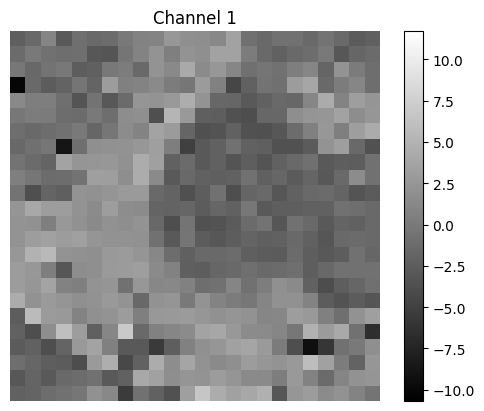

<Figure size 640x480 with 0 Axes>

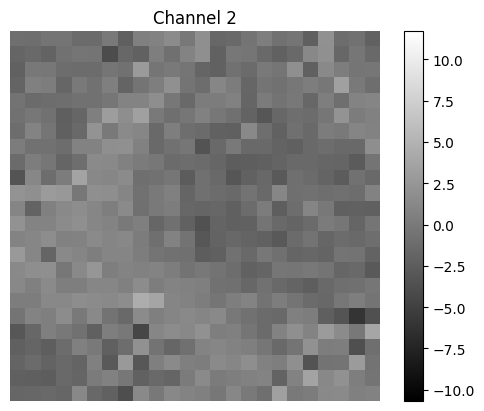

<Figure size 640x480 with 0 Axes>

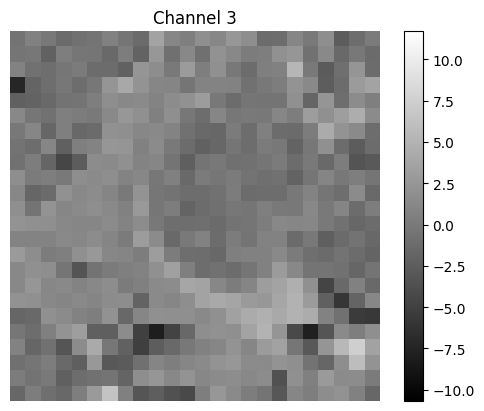

<Figure size 640x480 with 0 Axes>

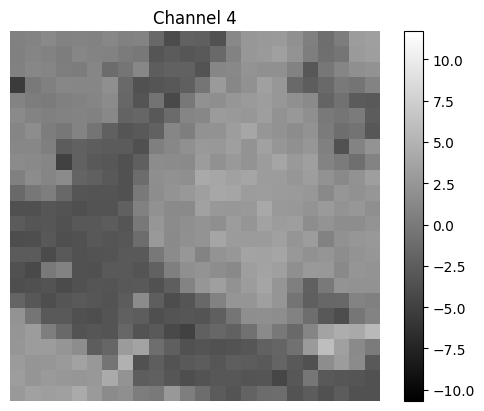

<Figure size 640x480 with 0 Axes>

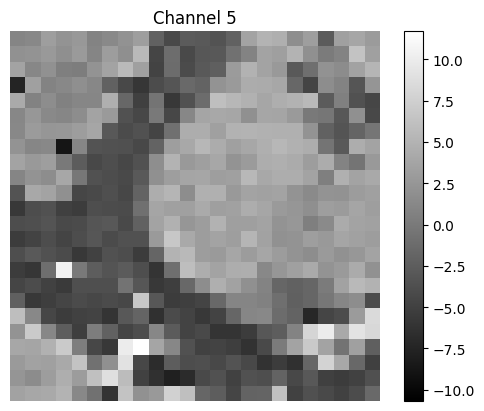

<Figure size 640x480 with 0 Axes>

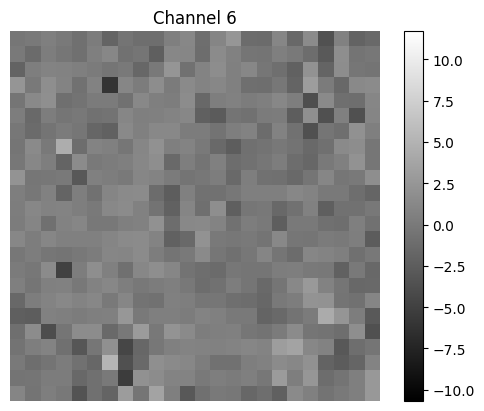

<Figure size 640x480 with 0 Axes>

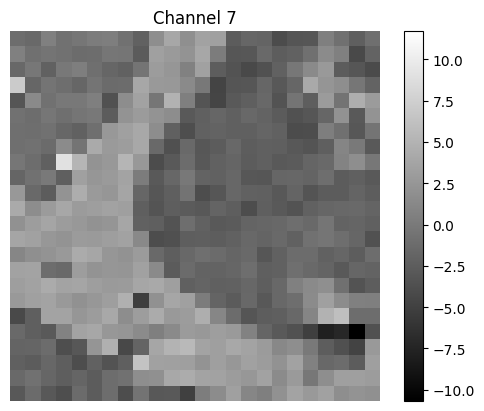

<Figure size 640x480 with 0 Axes>

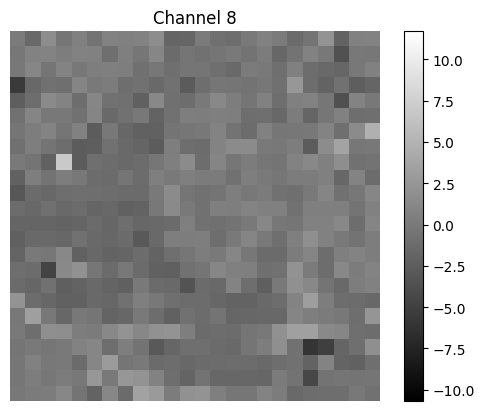

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

slice_idx = 15#60 // 4

vmin = enc_img[:, :, :, slice_idx].min().item()
vmax = enc_img[:, :, :, slice_idx].max().item()

for channel in range(enc_img.shape[0]):
    plt.figure()
    fig, ax = plt.subplots()

    # Rotate the image 90 degrees counterclockwise
    rotated_img = np.rot90(enc_img[channel, :, :, slice_idx].cpu().numpy())

    plt.imshow(rotated_img, vmin=vmin, vmax=vmax, cmap="gray")
    plt.title(f"Channel {channel+1}")

    plt.colorbar()
    
    plt.axis('off')  # Remove axis for cleaner visualization
    
    
    plt.show()

<font color="Purple">

#### GAN Hates -1000 Padded images, why?

</font>

gives checkerboard output

## 2.4 (Optional) Save/Load Stuff from Disk

### 2.4.1 Save Enc_cubes as dict object using Pickle

In [ ]:
encoded_images_dir = os.path.join(data_folder, "encoded_imgs")

#### 2.4.1.1 Save to Pickle

In [ ]:
import pickle

with open(os.path.join(encoded_images_dir, 'enc_healthy_cubes.pkl'), 'wb') as f:
    pickle.dump(enc_healthy_cubes, f)

with open(os.path.join(encoded_images_dir, 'enc_pancreatic_tumor_cubes.pkl'), 'wb') as f:
    pickle.dump(enc_pancreatic_tumor_cubes, f)

#### 2.4.1.2 Load from Pickle

In [ ]:
os.path.join(encoded_images_dir, 'enc_healthy_cubes.pkl')

'./data/encoded_imgs/enc_healthy_cubes.pkl'

In [ ]:
import pickle

with open(os.path.join(encoded_images_dir, 'enc_healthy_cubes.pkl'), 'rb') as f:
    enc_healthy_cubes = pickle.load(f)

with open(os.path.join(encoded_images_dir, 'enc_pancreatic_tumor_cubes.pkl'), 'rb') as f:
    enc_pancreatic_tumor_cubes = pickle.load(f)

In [ ]:
print("len enc_healthy_cubes:", len(enc_healthy_cubes))
print("len enc_pancreatic_tumor_cubes:", len(enc_pancreatic_tumor_cubes))

len enc_healthy_cubes: 42
len enc_pancreatic_tumor_cubes: 37


### 2.4.1 Save/Load encoded images as NII.GZ for viewing in ITK-SNAP

In [ ]:
encoded_imgs_folder = "encoded_imgs"
healthy_enc_imgs_folder = os.path.join(data_folder, encoded_imgs_folder, "healthy-pancreas")
pancreatic_tumor_enc_imgs_folder = os.path.join(data_folder, encoded_imgs_folder, "pancreatic-tumor")

In [ ]:
save_images_as_nifti(healthy_pancreas_enc_img_pairs, healthy_enc_imgs_folder)

Saving NIfTI files: 100%|██████████| 42/42 [00:28<00:00,  1.45image/s]

All NIfTI files saved successfully in './data/encoded_imgs/healthy-pancreas'


In [ ]:
save_images_as_nifti(pancreas_tumor_enc_img_pairs, pancreatic_tumor_enc_imgs_folder)

Saving NIfTI files: 100%|██████████| 89/89 [00:28<00:00,  3.13image/s]

All NIfTI files saved successfully in './data/encoded_imgs/pancreatic-tumor'


### 2.4.1 (Optional) Directly load saved encoded images

In [ ]:
import os

encoded_imgs_folder = "encoded_imgs"
healthy_enc_imgs_folder = os.path.join(data_folder, encoded_imgs_folder, "healthy-pancreas")
pancreatic_tumor_enc_imgs_folder = os.path.join(data_folder, encoded_imgs_folder, "pancreatic-tumor")

In [ ]:
healthy_patient_enc_img_folders = [os.path.join(healthy_enc_imgs_folder, j) for j in healthy_pancreas_ids]
pancreatic_tumor_enc_img_folders = [os.path.join(pancreatic_tumor_enc_imgs_folder, j) for j in pancreatic_tumor_ids]

In [ ]:
from tqdm import tqdm
import nibabel as nib

def load_encoded_imgs_in_folders(folders_list: list):
    encoded_cts = []
    for path in tqdm(folders_list, desc="Loading Encoded CT Scans"):
        encoded_cts.append(nib.load(os.path.join(path, ct_filename)).get_fdata())

    return encoded_cts

In [ ]:
healthy_pancreas_enc_imgs = load_encoded_imgs_in_folders(healthy_patient_enc_img_folders)
pancreatic_tumor_enc_imgs = load_encoded_imgs_in_folders(pancreatic_tumor_enc_img_folders)

Loading Encoded CT Scans: 100%|██████████| 89/89 [00:02<00:00, 38.03it/s]


In [ ]:
type(healthy_pancreas_enc_imgs[0])

numpy.ndarray

In [ ]:
healthy_pancreas_enc_imgs[0].shape

(100, 78, 50, 8)

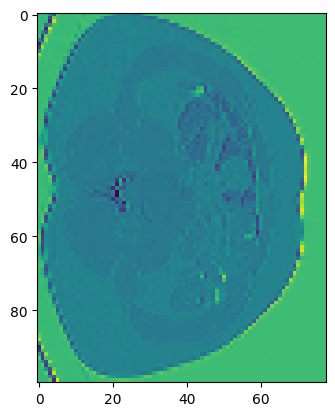

In [ ]:
from matplotlib import pyplot as plt


plt.imshow(healthy_pancreas_enc_imgs[0][:,:,0, 0])